In [1]:
import os
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import re

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', None)

### Finance Data

In [3]:
CLEAN_PATH = '../data/data_clean/us_school_districts.csv'

df = pd.read_csv(CLEAN_PATH)

In [4]:
finances_2016 = df[(df.YRDATA == 2016)]
finances_2016 = finances_2016.reset_index(drop=True)
finances_2016.head()

,STATE,ENROLL,NAME,YRDATA,TOTALREV,TFEDREV,TSTREV,TLOCREV,LOCRTAX,LOCRPROP,LOCREVPAR,PCTTOTAL,PCTFTOT,PCTSTOT,PCTLTOT,TOTALEXP,TCURSPND,TSALWAGE,TEMPBENE,TCURINST,TCURSSVC,PPCSTOT,PPITOTAL,PPSTOTAL
0,Alabama,9609.0,AUTAUGA COUNTY SCHOOL DISTRICT,2016,80867,7447,53842,19578,6797.0,6775.0,NaN,100.0,9.2,66.6,24.2,76672,74185.0,43030.0,18122.0,43843,23941,7622.0,4563.0,2492.0
1,Alabama,30931.0,BALDWIN COUNTY SCHOOL DISTRICT,2016,338236,23710,145180,169346,49106.0,48902.0,NaN,100.0,7.0,42.9,50.1,299880,281647.0,156502.0,61621.0,164977,97231,8942.0,5332.0,3143.0
2,Alabama,912.0,BARBOUR COUNTY SCHOOL DISTRICT,2016,10116,2342,5434,2340,1209.0,1202.0,NaN,100.0,23.2,53.7,23.1,10070,9778.0,5079.0,2064.0,4907,3896,10621.0,5380.0,4272.0
3,Alabama,2842.0,EUFAULA CITY SCHOOL DISTRICT,2016,26182,3558,15900,6724,2844.0,2836.0,NaN,100.0,13.6,60.7,25.7,29843,25477.0,14015.0,5746.0,15302,7901,8851.0,5384.0,2780.0
4,Alabama,3322.0,BIBB COUNTY SCHOOL DISTRICT,2016,32486,3664,21846,6976,1716.0,1572.0,NaN,100.0,11.3,67.2,21.5,31662,30616.0,17107.0,7057.0,16407,11087,8931.0,4882.0,3337.0


### Map Data

In [5]:
# Used to map state codes to state names for map data
state_map = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

In [6]:
# Import and configure map data
map_2016 = gpd.read_file('../data/data_clean/unsd_map/unsd_compiled.shp')

# Rename state column to align with finance data - astype int
map_2016 = map_2016.rename(columns={'STATEFP': 'STATE'})
map_2016.STATE = map_2016.STATE.astype(int)

# Exclude US territories (Codes above 56)
map_2016 = map_2016[map_2016.STATE <= 56]

# Map state codes to names
map_2016.STATE = map_2016.STATE.map(state_map)

In [7]:
map_2016.head()

,STATE,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,Alabama,00001,0100001,Fort Rucker School District,00,KG,12,G5420,B,E,233059995,2735224,+31.4097368,-085.7458071,"POLYGON ((-85.86572 31.45470, -85.86543 31.454..."
1,Alabama,00003,0100003,Maxwell AFB School District,00,KG,12,G5420,B,E,8476761,566857,+32.3809438,-086.3637490,"POLYGON ((-86.37655 32.39358, -86.37621 32.393..."
2,Alabama,00005,0100005,Albertville City School District,00,KG,12,G5420,None,E,68731806,258708,+34.2631303,-086.2106600,"MULTIPOLYGON (((-86.25104 34.25266, -86.25060 ..."
3,Alabama,00006,0100006,Marshall County School District,00,PK,12,G5420,None,E,1267142967,103647100,+34.3739971,-086.3442702,"MULTIPOLYGON (((-86.10870 34.19063, -86.10873 ..."
4,Alabama,00007,0100007,Hoover City School District,00,KG,12,G5420,None,E,121693900,2594832,+33.3769487,-086.8055789,"MULTIPOLYGON (((-86.66393 33.40902, -86.66333 ..."


### Data Cleaning - 'NAME'

In [264]:
# Create maps to replace abbreviations and drop words
def create_maps(abbreviation_map, drop_map):
    abbreviation_map = {rf'\b{i}\b': word for i, word in my_map.items()}
    drop_map = {rf'\b{i}\b': word for i, word in drop_map.items()}
    
    return(abbreviation_map, drop_map)

my_map = {'plt': 'plantation',
         'ex': 'exempted',
#          'vlg': 'village',
         'n': 'north',
         'mt': 'mount',
         'spgs': 'springs',
         'cons': 'consolidated',
         'community': 'county',
         'cnty': 'county',
         'cmnty': 'county',
         'comm': 'county',
         'com': 'county',
         'co': 'county',
         'inc': 'corporation',
         'ind': 'independent',
         'uni': 'unified',
         'unif': 'unified',
         'uf': 'union free',
         'hts': 'heights',
         'supv': 'supervisory',
         'ft': 'fort',
         'twp': 'township',
         'ctl': 'central',
         'elem': 'elementary'}

my_drop_map = {'schs': '',
            'sch': '',
            'sd': '',
            'dist': '',
            'disrict': '',
            'dis': '',
            'dst': '',
            'isd': '',
            'pub': '',
            'public': '',
            'school': '',
            'schools': '',
            'district': '',
            'borough': '',
            'boro': '',
            'area': '',
            'island': '',
            'islands': '',
            'department': '',
            'municipal': '',
            'consolidated': '',
            'city': '',
            'cty': '',
            'town': '',
            'merged': '',
            'cusd': '',
            'usd': '',
            'reg': '',
            'joint': '',
            'jt': '',
            'j': '',
            'voc': '',
            'village': '',
            'vil': '',
            'vlg': '',
            'vill': ''}

In [265]:
# Regex replacement dictionaries to clean district names
abbreviation_map, drop_map = create_maps(my_map, my_drop_map)

In [266]:
def clean_NAME(df):
    df.NAME = df.NAME.str.lower()
    
    # Replace abbreviations and drop non-essential words
    df.NAME = df.NAME.replace(abbreviation_map, regex=True)
    df.NAME = df.NAME.replace(drop_map, regex=True)
    
    # Drop 'r-' and 'r' from district codes [ need rX next]
    df.NAME = df.NAME.str.replace(rf" r-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" r ", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re ", ' ', regex=True)
    
    # Drop extra district codes found in '()'
    df.NAME = df.NAME.str.replace("\([^()]*\)", '', regex=True)
    
    # Drop '#' and '.' and '-' and '/' from districts
    df.NAME = df.NAME.str.replace('#', '', regex=False)
    df.NAME = df.NAME.str.replace('.', '', regex=False)
    df.NAME = df.NAME.str.replace('-', ' ', regex=False)
    df.NAME = df.NAME.str.replace('/', ' ', regex=False)
    
    # Hawaii edge case
    df['NAME'][df.STATE == 'Hawaii'] = 'hawaii'
    
    df = df.sort_values(['STATE', 'NAME'])
    return df

In [267]:
clean_f = clean_NAME(finances_2016)
clean_m = clean_NAME(map_2016)

#========================================================
# Unique state by state naming conventions clean up
#========================================================

# These states have disctrict codes in finance data but none in map data
extra_codes = ['Arizona', 
             'Arkansas', 
             'Minnesota',
             'Michigan',
             #'Missouri', 
             'Nebraska',
             'Oklahoma', 
             'Texas',
             'Washington', 
             'Wisconsin']


# Map data does not include district codes for the above states. Remove numbers from the above states
clean_f['NAME'][clean_f.STATE.isin(extra_codes)] = clean_f.NAME.str.replace(' \d+', '')

# Alabama finance data has extra descriptors - remove them
clean_f['NAME'][clean_f.STATE == 'Alabama'] = clean_f.NAME.str.replace('board of education', '', regex=False)

# Alaska finance data has extra descriptors - remove them
clean_f['NAME'][clean_f.STATE == 'Alaska'] = clean_f.NAME.str.replace('regional educational attendance', '', regex=False)

# Arizona has inconsistant 'unified' identifier - not required
clean_f['NAME'][clean_f.STATE == 'Arizona'] = clean_f.NAME.str.replace(rf'\bunified\b', '', regex=True)
clean_m['NAME'][clean_m.STATE == 'Arizona'] = clean_m.NAME.str.replace(rf'\bunified\b', '', regex=True)

# Arizona has extra 'and' words - remove them
clean_f['NAME'][clean_f.STATE == 'Arizona'] = clean_f.NAME.str.replace(rf'\band\b', '', regex=True)
clean_m['NAME'][clean_m.STATE == 'Arizona'] = clean_m.NAME.str.replace(rf'\band\b', '', regex=True)

# Minnesota finance data has extra descriptors - remove them
clean_f['NAME'][clean_f.STATE == 'Minnesota'] = clean_f.NAME.str.replace(rf'\bindependent\b', '', regex=True)

# Mississippi finance data has extra descriptors - remove them
clean_f['NAME'][clean_f.STATE == 'Mississippi'] = clean_f.NAME.str.replace(rf'\bmun\b', '', regex=True)
clean_f['NAME'][clean_f.STATE == 'Mississippi'] = clean_f.NAME.str.replace(rf'\bsep\b', '', regex=True)

# Nebraska map data has extra 'county' descriptor - remove them
clean_f['NAME'][clean_f.STATE == 'Nebraska'] = clean_f.NAME.str.replace(rf'\bcounty\b', '', regex=True)
clean_m['NAME'][clean_m.STATE == 'Nebraska'] = clean_m.NAME.str.replace(rf'\bcounty\b', '', regex=True)

# South Carolina has uneeded 'county' identifier that causes collision
clean_f['NAME'][clean_f.STATE == 'South Carolina'] = clean_f.NAME.str.replace(rf'\bcounty\b', '', regex=True)
clean_m['NAME'][clean_m.STATE == 'South Carolina'] = clean_m.NAME.str.replace(rf'\bcounty\b', '', regex=True)

# Utah has uneeded 'county' identifier
clean_f['NAME'][clean_f.STATE == 'Utah'] = clean_f.NAME.str.replace(rf'\bcounty\b', '', regex=True)


# Cleanup whitespace
clean_f.NAME = clean_f.NAME.str.rstrip()
clean_f.NAME = clean_f.NAME.replace("\s+", ' ', regex=True)
clean_m.NAME = clean_m.NAME.str.rstrip()
clean_m.NAME = clean_m.NAME.replace("\s+", ' ', regex=True)

C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\munoz\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value i

### Combining Finance and Map data

In [268]:
# Merge on an exact match of state and name of district, 
# only keep the geomtry data and convert to geodataframe
merged_df = clean_f.merge(clean_m[['STATE', 'NAME', 'geometry']], 
                                how='inner', 
                                on=['STATE', 'NAME'])

finances_map_2016 = gpd.GeoDataFrame(merged_df, geometry=merged_df.geometry)

print("The merged data accounts for {}% of the map data set.".format((len(finances_map_2016) / len(map_2016)) * 100))
print("{} data points.".format(len(finances_map_2016)))
# finances_map_2016.head()

The merged data accounts for 86.96171150491232% of the map data set.
9471 data points.


In [269]:
# The count of districts in each state in each data set (finances, map, combined)
dps_f = clean_f.groupby(['STATE'])['NAME'].count()
dps_m = clean_m.groupby(['STATE'])['NAME'].count()
dps_c = finances_map_2016.groupby(['STATE'])['NAME'].count()

sum_of_percents = (dps_c / dps_m).sum()
percent_mapped = (sum_of_percents / len(dps_c / dps_m)) * 100

print("{} / 51 State Districts successfully mapped to finance data.".format(sum_of_percents))
print('{}% of the map data linked to finace data.'.format((percent_mapped)))
print('='*50)
print(dps_c / dps_m * 100)

#Max so far = 41.293931568344554

45.22845856836181 / 51 State Districts successfully mapped to finance data.
88.68325209482708% of the map data linked to finace data.
STATE
Alabama                  96.376812
Alaska                  100.000000
Arizona                  94.897959
Arkansas                 97.008547
California               93.895349
Colorado                 74.157303
Connecticut              96.521739
Delaware                100.000000
District of Columbia    100.000000
Florida                  95.522388
Georgia                  86.187845
Hawaii                  100.000000
Idaho                    90.434783
Illinois                 80.729167
Indiana                  88.275862
Iowa                     91.071429
Kansas                   84.265734
Kentucky                 84.210526
Louisiana                92.753623
Maine                    61.570248
Maryland                 91.666667
Massachusetts            89.523810
Michigan                 88.030888
Minnesota                85.889571
Mississippi         

In [276]:
# Used for viewing data sets by state
state = 'Wyoming'

state_f = clean_f[clean_f.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
state_m = clean_m[clean_m.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
state_combined = finances_map_2016[finances_map_2016.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
not_combined_map = state_m.NAME[~state_m.NAME.isin(state_combined.NAME)]
not_combined_finance = state_f.NAME[~state_f.NAME.isin(state_combined.NAME)]
# print("FINANCES ({})".format(len(state_f)))
# print('='*15)
# print(state_f)
# print('='*75)

# print("MAP ({})".format(len(state_m)))
# print('='*15)
# print(state_m)
# print('='*75)

print('NOT COMBINED FROM MAP ({})'.format(len(not_combined_map)))
print('='*15)
print(not_combined_map)
print('='*75)

print('NOT COMBINED FROM FINANCES ({})'.format(len(not_combined_finance)))
print('='*15)
print(not_combined_finance)
print('='*75)

print('COMBINED ({})'.format(len(state_combined)))
print('='*15)
print(state_combined)


# print(state_m.info())

NOT COMBINED FROM MAP (7)
10890          not defined
10862    big horn county 3
10849    campbell county 1
10855       crook county 1
10869    niobrara county 1
10846    sublette county 9
10886    washakie county 2
Name: NAME, dtype: object
NOT COMBINED FROM FINANCES (7)
14314          big piney 9
14281     bighorn county 3
14282      campbell county
14287         crook county
14294    fremont county 38
14304      niobrara county
14321           washakie 2
Name: NAME, dtype: object
COMBINED (41)
        STATE                  NAME
9430  Wyoming       albany county 1
9431  Wyoming     big horn county 1
9432  Wyoming     big horn county 2
9433  Wyoming     big horn county 4
9434  Wyoming       carbon county 1
9435  Wyoming       carbon county 2
9436  Wyoming     converse county 1
9437  Wyoming     converse county 2
9438  Wyoming      fremont county 1
9439  Wyoming     fremont county 14
9440  Wyoming      fremont county 2
9441  Wyoming     fremont county 21
9442  Wyoming     fremont count

In [272]:
district = rf'\bcenter\b'

districts_f = clean_f[clean_f.NAME.str.contains(district, regex=True)].sort_values(by='NAME')
districts_m = clean_m[clean_m.NAME.str.contains(district)].sort_values(by='NAME')

print(districts_f[['STATE', 'NAME']])
print(districts_m[['STATE', 'NAME']])

                STATE                                               NAME
3718          Indiana              30 career center education interlocal
10984    Pennsylvania                          a w beattie career center
9495             Ohio                   allen educational service center
13998       Wisconsin                                        alma center
11575  South Carolina                 anderson 1 and 2 vocational center
9507             Ohio               ashtabula educational service center
9516             Ohio            athens meigs educational service center
9524             Ohio                auglaize educational service center
11581  South Carolina                         barnwell vocational center
11583  South Carolina                  beaufort jasper vocational center
3198         Illinois                             beck vocational center
11480    Pennsylvania                                   bethlehem center
3130         Illinois                      blooming

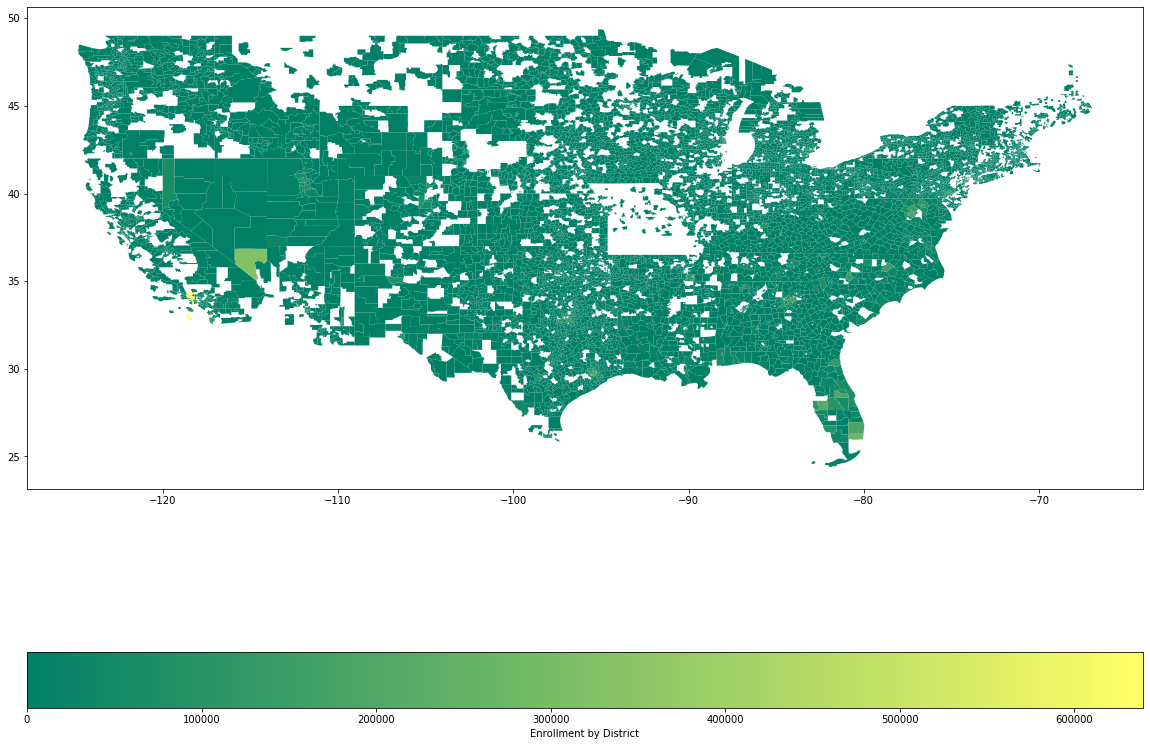

In [29]:
temp = finances_map_2016[~finances_map_2016.STATE.isin(['Alaska', 'Hawaii'])]
fig = temp.plot(column='ENROLL', cmap='summer', figsize = (20,20), legend=True, legend_kwds={'label': "Enrollment by District",
                                                                              'orientation': "horizontal"})


plt.show()

### Some Stuff?

In [147]:
SCHEMA = ['YRDATA',
'NAME',
'ENROLL',
'TOTALREV',
'TFEDREV',
'TSTREV',
'TLOCREV',
'LOCRTAX',
'LOCRPROP',
#'LOCREVPAR',
'PCTTOTAL',
'PCTFTOT',
'PCTSTOT',
'PCTLTOT',
'TOTALEXP',
'TCURSPND',
'TSALWAGE',
'TEMPBENE',
'TCURINST',
'TCURSSVC',
'PPCSTOT',
'PPITOTAL',
'PPSTOTAL']

def n_largest_or_smallest(df, n, operation):
    """Return a sorted df of the n most/least funded districts

        Parameters:
            df (dataframe): the dataframe to be modified
            n (int): the number of districts to keep
            operation (str)['smallest' or 'largest']: whether to return most/least funded 
        Returns:
            new_df (dataframe): A sorted dataframe of the n most/least funded districts in each state
    """
    
    if operation == 'largest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nlargest(n, columns='TOTALREV')) 
    elif operation == 'smallest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nsmallest(n, columns='TOTALREV'))
    else:
        print("operation must be 'largest' or 'smallest'")
        return
    
    return new_df

In [ ]:
least_funded = n_largest_or_smallest(df_2016, 3, 'smallest')
most_funded = n_largest_or_smallest(df_2016, 3, 'largest')

least_funded.head()
most_funded.head()